## Exercício: Modelo de Linguagem com auto-atenção

Este exercício é similar ao da aula passada, mas iremos agora treinar uma rede neural *com auto-atenção* para prever a próxima palavra de um texto, data as palavras anteriores como entrada.

Na camada de auto-atenção, deve-se implementar (vide slide 34):
- Embeddings de posição
- Projeções lineares (WQ, WK, WV, WO)
- Camada de feed forward (2-layer MLP)

Instrucões:
- É necessário fazer duas implementações da camada de auto-atenção: uma usando laços (ineficiente, mas fácil de entender) e outra matricial (eficiente mas difícil de entender). Usar slide 36 como referência.

- Fazer um assert para garantir que o resultado das duas implementações é exatamente igual.

- No treinamento, usar apenas a implementação matricial.

In [2]:
import string
from collections import Counter
from typing import List, Dict, Union, Tuple
import random
import os
import time
import abc

import numpy as np
from numpy.testing import assert_raises, assert_array_equal, assert_array_almost_equal
from numpy.typing import ArrayLike
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import wandb

In [3]:
def assert_array_not_equal(array1:ArrayLike, array2:ArrayLike) -> ArrayLike:
    assert_raises(AssertionError, assert_array_equal, array1, array2)

In [4]:
def reset_seeds() -> None:
    random.seed(18)
    torch.manual_seed(18)

## Faz download e carrega o dataset

In [5]:
if not os.path.isfile("67724.txt.utf-8"):
    !curl -LO https://www.gutenberg.org/ebooks/67724.txt.utf-8

if not os.path.isfile("67725.txt.utf-8"):
    !curl -LO https://www.gutenberg.org/ebooks/67725.txt.utf-8

In [6]:
text = open("67724.txt.utf-8","r", encoding="utf8").read()
text += open("67725.txt.utf-8","r", encoding="utf8").read()

paragraphs = text.split("\n\n")
len(paragraphs)

4969

In [7]:
def clean_text(text:str) -> str:
    '''
    Clean the text, changing upper case and setting numbers to 999
    '''
    
    text = text.lower()
    old_text = text.split()
    new_text = []

    for j in range(len(old_text)):
        word = old_text[j] 
        if word.isdigit():
            word = "999"
        elif len(word) > 1 and word[0] in string.punctuation:
            old_text.insert(j+1, word[1:])
            word = word[0]
        elif word[-1] in string.punctuation and len(word) > 1:
            old_text.insert(j+1, word[:-1])
            old_text.insert(j+2, word[-1])
            
            word = ""
        
        if len(word) > 0:
            new_text.append(word)
    
    return " ".join(new_text)

In [8]:
cleaned_paragraphs = [paragraph.replace("\n", " ") for paragraph in paragraphs if paragraph.strip()]

#Paper:
#ponctuation -> keep (separado das outras palavras, "pontuação," -> "pontuação"+",")
#numeric -> special symbol (colocando todos como 999 para convergir para o mesmo símbolo)
#upper -> lower
#proper nouns -> special symbol (difícil identificar, ignorado)
#rare words -> special symbol (feito na parte de encoding)

for i in range(len(cleaned_paragraphs)):
    cleaned_paragraphs[i] = clean_text(cleaned_paragraphs[i])

print("SAMPLE ----------------")
print(cleaned_paragraphs[0])
print("---------------------")

print(len(cleaned_paragraphs))

SAMPLE ----------------
﻿the project gutenberg ebook of o guarany : romance brazileiro , vol . 999 ( of 999 ) this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with almost no restrictions whatsoever . you may copy it , give it away or re-use it under the terms of the project gutenberg license included with this ebook or online at www.gutenberg.org . if you are not located in the united states , you
---------------------
4892


## Análise do dataset

In [9]:
def count_words(texts:List[str]) -> Counter:
    word_counts = Counter()
    for text in texts:
        word_counts.update(text.split(" "))
    return word_counts

word_counts = count_words(cleaned_paragraphs)

len(word_counts)

11470

## Criando um vocabulário

In [10]:
def create_vocab(word_counts:Counter, vocab_size:int) -> Tuple[Dict[str, int], List[str]]:
    most_frequent_words = [word for word, count in word_counts.most_common(vocab_size)]
    vocab = {word: i for i, word in enumerate(most_frequent_words, 1)}

    inverse_vocab = list(vocab.keys())

    return vocab, inverse_vocab

In [11]:
test_vocab_size = 1000
test_vocab, test_inverse_vocab = create_vocab(word_counts, test_vocab_size)

In [12]:
test_vocab

{',': 1,
 'a': 2,
 'que': 3,
 '-': 4,
 'o': 5,
 'de': 6,
 'e': 7,
 ';': 8,
 '.': 9,
 'um': 10,
 'do': 11,
 'não': 12,
 'uma': 13,
 'os': 14,
 'se': 15,
 'da': 16,
 'com': 17,
 'sua': 18,
 'para': 19,
 'seu': 20,
 'em': 21,
 'pery': 22,
 'as': 23,
 'no': 24,
 'por': 25,
 'como': 26,
 'ao': 27,
 'era': 28,
 'tinha': 29,
 'á': 30,
 'cecilia': 31,
 'na': 32,
 'd': 33,
 'sobre': 34,
 'é': 35,
 'mas': 36,
 'the': 37,
 '!': 38,
 'elle': 39,
 'dos': 40,
 'indio': 41,
 'quando': 42,
 'seus': 43,
 ':': 44,
 'antonio': 45,
 'mais': 46,
 'alvaro': 47,
 'of': 48,
 'das': 49,
 'lhe': 50,
 'olhos': 51,
 'depois': 52,
 'menina': 53,
 '?': 54,
 'ella': 55,
 'pela': 56,
 'disse': 57,
 'havia': 58,
 'fidalgo': 59,
 'tu': 60,
 'ainda': 61,
 'isabel': 62,
 'senhora': 63,
 'momento': 64,
 'estava': 65,
 'aventureiros': 66,
 'loredano': 67,
 'project': 68,
 'dous': 69,
 'casa': 70,
 'to': 71,
 'me': 72,
 'tempo': 73,
 'só': 74,
 'já': 75,
 'nos': 76,
 'mariz': 77,
 'italiano': 78,
 'todos': 79,
 '_': 80,
 'm

### Codificando e Decodificando sentenças

In [13]:
def encode_sentence(sentence:Union[str,List[str]], vocab:Dict) -> List[int]:
    if isinstance(sentence, list):
        words = sentence
    else:
        words = sentence.split(" ")
    
    return [vocab.get(word, 0) for word in words]

In [14]:
def decode_sentence(encoding, inverse_vocab):
    result = []

    for encoding_i in encoding:
        if encoding_i == 0:
            result.append("???")
        else:
            result.append(inverse_vocab[encoding_i-1])

    return result

## Classe do dataset

In [15]:
def create_sequences(texts:List[str], context_size:int, 
                     vocab:Dict) -> Tuple[List[List[int]], List[int]]:


    x_all = []
    y_all = []

    for paragraph in texts:
        start = 0
        end = context_size

        paragraph = encode_sentence(paragraph, vocab)

        while end < len(paragraph):
            x = paragraph[start:end]
            y = paragraph[end]

            if not ( 0 in x or 0 == y):
                x_all.append(x)
                y_all.append(y)

            start += 1
            end += 1
            
    x_all = np.array(x_all)
    y_all = np.array(y_all)

    return x_all, y_all

In [16]:
test_context_size = 10

test_x_all, test_y_all = create_sequences(cleaned_paragraphs, test_context_size, test_vocab)

In [17]:
assert len(test_x_all) == len(test_y_all)

In [18]:
#Embaralhando para evitar viés

def shuffle_dataset(x:List, y:List) -> Tuple[List, List]:

    indexes = list(range(len(x)))
    random.shuffle(indexes)

    x = x[indexes]
    y = y[indexes]

    return x, y

In [19]:
def separate_dataset(x_all:List, y_all:List) -> Tuple[Tuple[List, List], Tuple[List, List], Tuple[List, List]]:
    size_all = len(x_all)

    cut1 = int(0.6*size_all)
    cut2 = int(0.8*size_all)

    x_train = x_all[0:cut1]
    y_train = y_all[0:cut1]

    x_val = x_all[cut1:cut2]
    y_val = y_all[cut1:cut2]

    x_test = x_all[cut2:]
    y_test = y_all[cut2:]

    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

In [20]:
(test_x_train, test_y_train), (test_x_val, test_y_val), (test_x_test, test_y_test) = separate_dataset(test_x_all, test_y_all)

In [21]:
assert len(test_x_train)+len(test_x_val)+len(test_x_test) == len(test_x_all)

In [22]:
class TextPredictDataset(Dataset):
    def __init__(self, x_data:List[int], y_data:List[int]):
        self._x_data = torch.tensor(x_data)-1
        self._y_data = torch.tensor(y_data, dtype=torch.int64)-1
        
        if len(x_data) != len(y_data):
            raise ValueError(f"x_data and y_data must have same size. ({len(x_data)} ≠ {len(y_data)})")
        
        self._size = len(x_data)

    def __len__(self):
        return self._size

    def __getitem__(self, idx):
        return self._x_data[idx], self._y_data[idx]


In [23]:
test_train_dataset = TextPredictDataset(test_x_train, test_y_train)

In [24]:
assert_array_equal(test_train_dataset[0][0].shape, [test_context_size])
assert_array_equal(test_train_dataset[0][1].shape, [])

In [25]:
test_batch_size = 5

In [26]:
test_train_loader = DataLoader(test_train_dataset, batch_size=test_batch_size, shuffle=True)

In [27]:
test_data = next(iter(test_train_loader))

In [28]:
assert_array_equal(test_data[0].shape, [test_batch_size, test_context_size])
assert_array_equal(test_data[1].shape, [test_batch_size])

## Juntando tudo

In [29]:
def create_data_loaders(texts:List[str], vocab_size:int, context_size:int, batch_size:int) -> Tuple[Dict, List, DataLoader, DataLoader, DataLoader]:
    word_counts = count_words(texts)
    vocab, inverse_vocab = create_vocab(word_counts, vocab_size)

    x_all, y_all = create_sequences(texts, context_size, vocab)
    
    x_all, y_all = shuffle_dataset(x_all, y_all)

    (x_train, y_train), (x_val, y_val), (x_test, y_test) = separate_dataset(x_all, y_all)

    train_dataset = TextPredictDataset(x_train, y_train)
    val_dataset = TextPredictDataset(x_val, y_val)
    test_dataset = TextPredictDataset(x_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return vocab, inverse_vocab, train_loader, val_loader, test_loader

## Model

### Attention

In [30]:
class SingleHeadAttentionBase(torch.nn.Module, abc.ABC):
    def __init__(self, embed_dim:int) -> None:
        super().__init__()
        
        #d_model = dv = dk = embed_dim
        #h = 1

        wQ = torch.Tensor(embed_dim, embed_dim) #embed, embed
        wK = torch.Tensor(embed_dim, embed_dim) #embed, dk
        wV = torch.Tensor(embed_dim, embed_dim) #embed, dv
        w0 = torch.Tensor(embed_dim, embed_dim) #embed, embed

        self.wQ = torch.nn.Parameter(wQ)
        self.wK = torch.nn.Parameter(wK)
        self.wV = torch.nn.Parameter(wV)
        self.w0 = torch.nn.Parameter(w0)

        self.register_buffer("dk_root", torch.sqrt(torch.tensor(embed_dim, dtype=torch.float32)))

        for w in [self.wQ, self.wK, self.wV, self.w0]:
            torch.nn.init.xavier_uniform_(w)
    
    @abc.abstractmethod
    def forward(self, query:torch.Tensor, key:torch.Tensor, value:torch.Tensor) -> torch.Tensor:
        ...
        

In [31]:
class SingleHeadAttention(SingleHeadAttentionBase):

    def __init__(self, embed_dim: int) -> None:
        super().__init__(embed_dim)

    def forward(self, query:torch.Tensor, key:torch.Tensor, value:torch.Tensor) -> torch.Tensor:        
        #Transpose weights because PyTorch does that
        Q = query @ self.wQ.T
        K = key @ self.wK.T
        V = value @ self.wV.T

        scores = Q @ K.permute(0,2,1)
        scores /= self.dk_root
        probs = torch.softmax(scores, dim=-1)
        E = probs @ V

        result = E @ self.w0.T 

        return result


In [32]:
class SingleHeadAttentionLoop(SingleHeadAttentionBase):
    def __init__(self, embed_dim: int) -> None:
        super().__init__(embed_dim)


    def forward(self, query:torch.Tensor, key:torch.Tensor, value:torch.Tensor) -> torch.Tensor:
        batch_size = query.shape[0]
        sequence_size = query.shape[1]
        
        result = torch.empty_like(query)
        scores = torch.empty(sequence_size, device=query.device)

        for batch_index in range(batch_size):
            for word_index in range(sequence_size):
                xq = query[batch_index, word_index]
                q = xq @ self.wQ.T
                
                for key_index in range(sequence_size):
                    xk = key[batch_index][key_index]
                    k = xk @ self.wK.T
                    score = q @ k.T
                    scores[key_index] = score
                
                scores /= self.dk_root
                probs = torch.softmax(scores, dim=-1)

                e = 0
                for xv, p in zip(value[batch_index], probs):
                    v = xv @ self.wV.T
                    e += p*v
                
                e = e @ self.w0.T

                result[batch_index, word_index] = e

        return result
            

In [33]:
test_embed_dim = 5
matrix_version = SingleHeadAttention(test_embed_dim).eval()
loop_version = SingleHeadAttentionLoop(test_embed_dim).eval()
torch_version = torch.nn.MultiheadAttention(test_embed_dim, num_heads=1, bias=False, batch_first=True).eval()

In [34]:
wQ = matrix_version.wQ
wK = matrix_version.wK
wV = matrix_version.wV
w0 = matrix_version.w0

loop_version.wQ = wQ
loop_version.wK = wK
loop_version.wV = wV
loop_version.w0 = w0

torch_version.in_proj_weight = torch.nn.Parameter(torch.concat((wQ, wK, wV)))
torch_version.out_proj.weight = w0

In [35]:
test_data = torch.rand(2, 3, test_embed_dim) #2 batchs, sequences of 3 words, embed_dim

In [36]:
result_matrix = matrix_version(test_data, test_data, test_data)
result_loop = loop_version(test_data, test_data, test_data)
result_torch, _ = torch_version(test_data, test_data, test_data, need_weights=False)

result_matrix = result_matrix.detach()
result_loop = result_loop.detach()
result_torch = result_torch.detach()

C:\Users\Elton\AppData\Local\Temp\ipykernel_30444\2878972573.py:21: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3641.)
  score = q @ k.T


In [37]:
assert result_matrix.shape == result_torch.shape
assert result_loop.shape == result_torch.shape

assert_array_almost_equal(result_matrix, result_torch, decimal=5)
assert_array_almost_equal(result_matrix, result_loop)

In [38]:
#%timeit matrix_version(test_data, test_data, test_data)
#%timeit loop_version(test_data, test_data, test_data)
#%timeit torch_version(test_data, test_data, test_data, need_weights=False)

Matrix: 112 µs ± 1.77 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)\
Loop: 1.79 ms ± 15.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)\
Torch: 218 µs ± 4.81 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)

### Positional Encoding

In [39]:
class SinePositionalEncoding(torch.nn.Module):
    def __init__(self, embed_dim:int, sequence_size:int) -> None:
        super().__init__()

        position = torch.arange(sequence_size, dtype=torch.float32)
        expoent = 2.0*torch.arange(embed_dim, dtype=torch.float32)/embed_dim

        pe = torch.empty((sequence_size, embed_dim))

        pe.T[:] = position
        pe /= torch.pow(1e4, expoent)

        pe[:, 0::2] = torch.sin(pe[:, 0::2])
        pe[:, 1::2] = torch.cos(pe[:, 1::2])

        self.register_buffer("pe", pe)

    def forward(self, input_tensor:torch.Tensor) -> torch.Tensor:
        output = input_tensor + self.pe

        return output
        

In [40]:
test_embed_dim = 5
test_sequence_size = 3

test_data = torch.zeros(2, test_sequence_size, test_embed_dim) #2 batchs, sequences of 3 words, embed_dim

positional_encoding = SinePositionalEncoding(test_embed_dim, test_sequence_size)

result = positional_encoding(test_data)

assert_array_equal(result[0], result[1]) #Correct operation across batchs
assert_array_not_equal(result[0, 0], result[0, 1]) #Different positions -> Different encodings
assert_array_not_equal(result[0,:,0], result[0,:,1]) #Different dimensions -> Different encodings
assert len(list(positional_encoding.parameters())) == 0 #No trainable parameters

### Embedding

In [41]:
class Embedding(torch.nn.Module):
    def __init__(self, embed_dim:int, vocab_size:int) -> None:
        super().__init__()

        C = torch.Tensor(vocab_size, embed_dim)
        nn.init.xavier_uniform_(C)
        self.C = torch.nn.Parameter(C)

    def forward(self, input_tensor:torch.Tensor) -> torch.Tensor:
        #OBS: I checked, "index_select" doesn't work with batchs, "index" (third parameter) must be 1-D
        result = torch.stack([torch.index_select(self.C, 0, input_i) for input_i in input_tensor])
        
        return result

In [42]:
test_embed_dim = 2
test_vocab_size = 3
test_sequence_size = test_vocab_size

test_data = torch.empty((2, test_sequence_size), dtype=int)
test_data[:] = torch.arange(test_vocab_size)

embedding = Embedding(test_embed_dim, test_vocab_size)

result = embedding(test_data)
result = result.detach()

C = embedding.C.detach()

assert_array_equal(C.shape, [test_vocab_size, test_embed_dim]) #C matrix have correct shape
assert_array_equal(result.shape, [2, test_sequence_size, test_embed_dim])
assert_array_equal(result[0], result[1]) #Correct operation across batchs
assert_array_equal(result[0, 0], C[0]) #First result = embedding of first word

### Model

In [43]:
class LanguageModel(torch.nn.Module):
    def __init__(self, embed_dim:int, vocab_size:int, sequence_size:int, droput_rate:float=0.0) -> None:
        super().__init__()

        self.embedding = Embedding(embed_dim, vocab_size)

        self.positional_encoding = SinePositionalEncoding(embed_dim, sequence_size)
        self.dropout_encoding = torch.nn.Dropout(droput_rate)

        self.attention = SingleHeadAttention(embed_dim)
        self.dropout_attention = torch.nn.Dropout(droput_rate)

        self.linear1 = torch.nn.Linear(embed_dim, 4*embed_dim)
        self.dropout_linear1 = torch.nn.Dropout(droput_rate)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(4*embed_dim, embed_dim)
        self.dropout_linear2 = torch.nn.Dropout(droput_rate)

        self.linear_out = torch.nn.Linear(sequence_size*embed_dim, vocab_size)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        y = self.embedding(x)
        y = self.dropout_encoding(self.positional_encoding(y))
        y = self.dropout_attention(self.attention(y, y, y))

        y = self.dropout_linear1(self.linear1(y))
        y = self.dropout_linear2(self.linear2(y))

        #Linears inside encoders(above): equal for every position (Attention is all you need)
        #Linear for output: use the entery sequence -> Flatten
        y = y.flatten(start_dim=1)
        
        y = self.linear_out(y)

        return y

#### Model test

In [44]:
test_batch_size = 5
test_embed_dim = 2
test_vocab_size = 3
test_sequence_size = test_vocab_size

test_model = LanguageModel(test_embed_dim, test_vocab_size, test_sequence_size)

In [45]:
test_data = torch.empty((test_batch_size, test_sequence_size), dtype=int)
test_data[:] = torch.arange(test_sequence_size)

inputs = test_data
targets = test_vocab_size*torch.rand(test_batch_size).long()

output = test_model(inputs)
result = output.argmax(dim=1)

assert_array_equal(output.shape, [test_batch_size, test_vocab_size])
assert_array_equal(result.shape, targets.shape)

#### Train test

In [46]:
old_C = test_model.embedding.C.detach().numpy().copy()
old_wQ = test_model.attention.wQ.detach().numpy().copy()
old_wK = test_model.attention.wK.detach().numpy().copy()
old_wV = test_model.attention.wV.detach().numpy().copy()
old_w0 = test_model.attention.w0.detach().numpy().copy()


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(test_model.parameters(), lr=100)

test_model.train()

logits = test_model(inputs)
loss = criterion(logits.squeeze(), targets)
optimizer.zero_grad()
loss.backward()
optimizer.step()

new_C = test_model.embedding.C.detach().numpy()
new_wQ = test_model.attention.wQ.detach().numpy()
new_wK = test_model.attention.wK.detach().numpy()
new_wV = test_model.attention.wV.detach().numpy()
new_w0 = test_model.attention.w0.detach().numpy()

assert_array_not_equal(old_C, new_C)
assert_array_not_equal(old_wQ, new_wQ) 
assert_array_not_equal(old_wK, new_wK)
assert_array_not_equal(old_wV, new_wV)
assert_array_not_equal(old_w0, new_w0)

## Training

In [47]:
# Verifica se há uma GPU disponível e define o dispositivo para GPU se possível, caso contrário, usa a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Helper functions

In [48]:
def ppl(loss:torch.Tensor) -> torch.Tensor:
    return torch.exp(loss)

In [49]:
def compute_loss(model:torch.nn.Module, loader:DataLoader, criterion:torch.nn.Module) -> torch.Tensor:
    model.eval()

    with torch.no_grad():
        total_loss = 0
        n = 0
        for inputs, targets in loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            logits = model(inputs)
            loss = criterion(logits.squeeze(), targets)
            total_loss += loss*targets.size(0)

            n += targets.size(0)

        total_loss /= n 
    
    return total_loss.detach()

In [50]:
def print_info(loss_value:torch.Tensor, epoch:int, total_epochs:int, time:float=0.0):
    ppl_value = ppl(loss_value)

    
    print(f'Epoch [{epoch+1}/{total_epochs}], \
            Loss: {loss_value.item():.4f}, \
            Perplexity: {ppl_value.item():.4f}', end="")
    
    if time != 0:
        print(f", Elapsed Time: {time:.2f} sec")    
    else:
        print("")

### Train

In [51]:
raise ValueError

ValueError: 

In [117]:
vocab_size = 3000 # Quantidade de palavras no vocabulário
context_size = 5 # n palavras de entrada. O target é a próxima palavra
embed_dim = 64 # Tamanho do feature vector de cada palavra
epochs = 10 # Quantidade de epochs que serão treinadas
lr = 5e-3 # Taxa de treinamento
weight_decay = 1e-3 # Regularização L2
batch_size = 32
optimizer_class = torch.optim.SGD
dropout_rate = 0.1

In [118]:
reset_seeds()

In [119]:
vocab, inverse_vocab, train_loader, val_loader, test_loader = create_data_loaders(cleaned_paragraphs, vocab_size, context_size, batch_size)

model = LanguageModel(embed_dim, vocab_size, context_size, dropout_rate)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optimizer_class(model.parameters(), lr=lr, weight_decay=weight_decay)

In [120]:
torch.autograd.set_detect_anomaly(False)

In [121]:
config = {
    "vocab_size": vocab_size,
    "context_size": context_size,
    "embed_dim": embed_dim,
    "epochs": epochs,
    "lr": lr,
    "weight_decay": weight_decay,
    "batch_size": batch_size,
    "optimizer_class": optimizer_class.__name__,
    "dropout_rate": dropout_rate
}

wandb.init(project="IA024-03-Attention", config=config)

In [122]:
hist = {}
hist["loss_train"] = []
hist["loss_val"] = []
hist["ppl_train"] = []
hist["ppl_val"] = []

prev_loss = compute_loss(model, train_loader, criterion)
print_info(prev_loss, -1, epochs, 0)

for epoch in range(epochs):
    start_time = time.time() 

    model.train()

    loss_train = torch.tensor(0, dtype=torch.float32)
    n_train = 0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        logits = model(inputs)
        loss : torch.Tensor = criterion(logits.squeeze(), targets)

        loss_train += loss*targets.size(0)
        n_train += targets.size(0)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    end_time = time.time() 
    epoch_duration = end_time - start_time 

    loss_train /= n_train
    ppl_train = ppl(loss_train)

    print_info(loss_train, epoch, epochs, epoch_duration)
    
    print("VAL ", end="")
    loss_val = compute_loss(model, val_loader, criterion)
    ppl_val = ppl(loss_val)
    print_info(loss_val, epoch, epochs)

    hist["loss_train"].append(loss_train.item())
    hist["loss_val"].append(loss_val.item())
    hist["ppl_train"].append(ppl_train.item())
    hist["ppl_val"].append(ppl_val.item())

    log = {
        "loss_train": loss_train.item(),
        "loss_val": loss_val.item(),
        "ppl_train": ppl_train.item(),
        "ppl_val": ppl_val.item()
    }

    wandb.log(log)

for key in hist:
    hist[key] = np.array(hist[key])

wandb.finish()

Epoch [0/10],             Loss: 8.0055,             Perplexity: 2997.3779
Epoch [1/10],             Loss: 6.7056,             Perplexity: 816.9948, Elapsed Time: 9.41 sec
VAL Epoch [1/10],             Loss: 6.2391,             Perplexity: 512.4013
Epoch [2/10],             Loss: 6.2073,             Perplexity: 496.3745, Elapsed Time: 7.37 sec
VAL Epoch [2/10],             Loss: 6.1460,             Perplexity: 466.8596
Epoch [3/10],             Loss: 6.1370,             Perplexity: 462.6624, Elapsed Time: 7.45 sec
VAL Epoch [3/10],             Loss: 6.1223,             Perplexity: 455.9274
Epoch [4/10],             Loss: 6.1100,             Perplexity: 450.3461, Elapsed Time: 7.54 sec
VAL Epoch [4/10],             Loss: 6.1108,             Perplexity: 450.7205
Epoch [5/10],             Loss: 6.0914,             Perplexity: 442.0302, Elapsed Time: 7.45 sec
VAL Epoch [5/10],             Loss: 6.1045,             Perplexity: 447.8880
Epoch [6/10],             Loss: 6.0839,             Perp

loss_train,█▃▂▂▁▁▁▁▁▁
loss_val,█▃▂▂▁▁▂▁▁▁
ppl_train,█▂▂▁▁▁▁▁▁▁
ppl_val,█▃▂▂▁▁▂▁▁▁
loss_train,6.05851
loss_val,6.09626
ppl_train,427.73572
ppl_val,444.19446


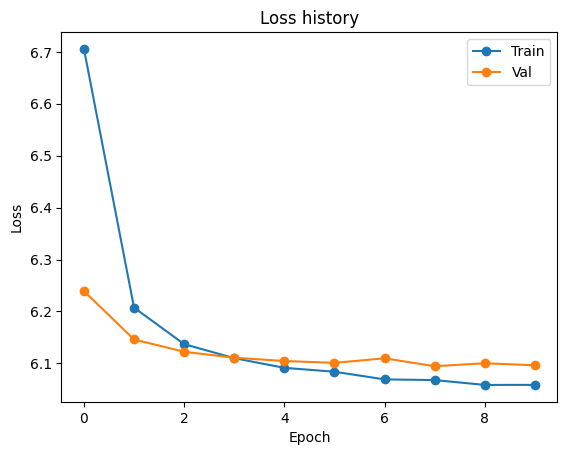

In [123]:
plt.plot(hist["loss_train"], "o-")
plt.plot(hist["loss_val"], "o-")

plt.legend(["Train", "Val"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss history")

plt.show()

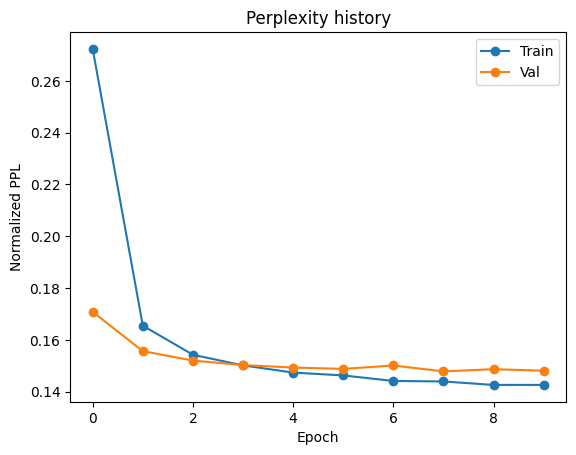

In [124]:
plt.plot(hist["ppl_train"]/vocab_size, "o-")
plt.plot(hist["ppl_val"]/vocab_size, "o-")

plt.legend(["Train", "Val"])
plt.xlabel("Epoch")
plt.ylabel("Normalized PPL")
plt.title("Perplexity history")

plt.show()

In [125]:
raise ValueError

ValueError: 

## Avaliação

In [ ]:
test_loss = compute_loss(model, test_loader, criterion)
test_ppl = ppl(test_loss)

test_ppl.item()

## Exemplo de uso

In [ ]:
def generate_text(model, vocab:Dict, inverse_vocab:List, text:str, max_length:int):
    text = clean_text(text)

    total_length = len(text.split(" "))

    last_sequence = create_sequences([text], context_size, vocab)[0][-1]
    last_sequence = torch.tensor(last_sequence)-1
    last_sequence = last_sequence.to(device)

    new_characters = []

    while total_length < max_length:
        
        output = model(torch.unsqueeze(last_sequence, 0))
        
        next_encoded = output.argmax(dim=1).item()

        last_sequence = torch.cat((last_sequence[1:], torch.tensor([next_encoded]).to(device)))
        
        new_characters.append(next_encoded)

        total_length += 1

    new_characters = np.array(new_characters)+1

    new_text = " ".join(decode_sentence(new_characters, inverse_vocab))

    return new_text

In [ ]:
text = cleaned_paragraphs[300]
max_length = 40

new_text = generate_text(model, vocab, inverse_vocab, text, max_length)

print("OLD")
print(text)
print("")
print("GENERATED CONTINUATION")
print(new_text)